In [1]:
import numpy as np
import pandas as pd
import math
from math import log
from sklearn.metrics import accuracy_score
import re
from collections import Counter

In [2]:
path = "C:\\Users\\22682\\Desktop\\datafortest.csv"
data = pd.read_csv(path)
data.head()

,编号,年龄,有工作,有房子,信用,类别
0,0,青年,否,否,一般,否
1,1,青年,否,否,好,否
2,2,青年,是,否,好,是
3,3,青年,是,是,一般,是
4,4,青年,否,否,一般,否


In [3]:
train_data = data.drop(['编号'],axis=1)
train_data.head()

,年龄,有工作,有房子,信用,类别
0,青年,否,否,一般,否
1,青年,否,否,好,否
2,青年,是,否,好,是
3,青年,是,是,一般,是
4,青年,否,否,一般,否


In [4]:
class Node:
    def __init__(self, root=True, label=None, attri_name=None):
        self.root = root ## 是否为根节点
        self.label = label ## 节点的标签
        self.attri_name = attri_name ## 节点的属性名字
        self.tree = {} ## 某个节点的子树
        self.result = {
            'label:': self.label,
            'attri_name':self.attri_name,
            'tree': self.tree,
            'root': self.root
        }

    def add_node(self, val, node): ## 根据属性的划分取值val，继续建立节点。
        self.tree[val] = node
    
    def __repr__(self):
        return '{}'.format(self.result)

In [5]:

class ID3_DTree:
    def __init__(self, epsilon=0.1):
        self.epsilon = epsilon
        self._tree = {}

    # 熵
    def calcEnt(self, y_label):
        num_samples = y_label.shape[0]
        cnt = Counter(y_label) ## return a dictionary
        ent = -sum([(p / num_samples) * log(p / num_samples, 2) for p in cnt.values()])
        return ent


    # 条件熵

    def condEnt(self, attri_data, y_label):
        num_samples = y_label.shape[0]
        attri_cnt = Counter(attri_data) ## return a dictionary
        cond_ent = 0
        for key in attri_cnt:
            attri_key_label = y_label[attri_data==key]
            cond_ent += len(attri_key_label)/num_samples * self.calcEnt(attri_key_label)
        return cond_ent

    ## 特征属性选择

    def OptAttri(self,train_data):
        infoGain =0 
        y_label = train_data.iloc[:,-1]
        attri_num = train_data.shape[1]-1
        for i in range (attri_num):
            attri_data = train_data.iloc[:,i]
            ent = self.calcEnt(y_label)
            cond_ent = self.condEnt(attri_data, y_label)
            infoGain_tmp = ent-cond_ent
            if infoGain_tmp > infoGain:
                infoGain = infoGain_tmp
                opt_attr = train_data.columns[i] ## attri name
        return opt_attr, infoGain

    def train(self, train_data):
        """
        input:数据集D(DataFrame格式)，特征集A，阈值eta
        output:决策树T
        """
        y_label = train_data.iloc[:,-1]
        feature_space = train_data.columns[:-1] ## feature names
                                                                                
        features = train_data.iloc[:,:-1]
    
        # 1,若D中实例属于同一类Ck，即y_label 中的类别个数为1，则T为单节点树，并将类Ck作为结点的类标记，返回T
        if len(y_label.value_counts()) == 1: 
            return Node(root=True, label=y_label.iloc[0])

        # 2, 若特征属性A为空，则T为单节点树，将D中样本数最多的类Ck作为该节点的类标记，返回T
        if len(feature_space) == 0:
            return Node(root=True,label=y_label.value_counts().sort_values(ascending=False).index[0])

        # 3,若不是上述情况，需要计算信息增益, 选择信息增益最大的属性做为待选根节点属性Ag
        opt_attr_name, max_infoGain= self.OptAttri(train_data)
        
        # 4,若Ag的信息增益小于阈值eta,则置T为单节点树，并将D中是样本数最多的类Ck作为该节点的类标记，返回T
        if max_infoGain < self.epsilon:
            return Node(root=True,label=y_train.value_counts().sort_values(ascending=False).index[0])

        # 5,若Ag的infogain大于阈值eta，则需要构建Ag子集
        node_tree = Node(root=False, attri_name=opt_attr_name)
        feature_list = train_data[opt_attr_name].value_counts().index ## 已选属性的子属性的名称
       
         ## 需要确定每个子属性下面的样本子集，并且根据其他属性对样本子集继续进行树的划分 （去除根属性）
        for f in feature_list:
            sub_train_df = train_data.loc[train_data[opt_attr_name] ==f].drop([opt_attr_name], axis=1)

         # 6, 递归生成树：对样本子集继续进行树的划分
            sub_tree = self.train(sub_train_df)
            node_tree.add_node(f, sub_tree)
        return node_tree

    def fit(self, train_data):
        Dtree = self.train(train_data)
        return Dtree

    
    def predict(self, root, test_data_Frame): ## test_data_Frame （针对西瓜例子，没有编号这个属性）, root 是建立好的树
        root0= root
        testNum = test_data_Frame.shape[0]
        pred=[]
        for i in range(testNum): 
            root = root0
            test_data = test_data_Frame.iloc[i:i+1,:]
          
            while root.attri_name!=None: ## 说明根节点可以划分
                attri_val = test_data[root.attri_name].values[0] # 根节点的属性取值
                if attri_val in root.tree: # 若存在子树，则将此时的属性节点当成根节点，直到不能划分时，即为叶节点
                    root = root.tree[attri_val]
                else:
                    break
            y_pred = root.label
            pred.append(y_pred)
        return pred

In [6]:
dt = ID3_DTree()
Dtree = dt.fit(train_data)

In [7]:
from pydotplus import graphviz
import re
from IPython.display import display, Image

def tree2graph(i, g, root):
    if root.attri_name == None:
        g_node_label = f'Node:{i}\n属性:{root.attri_name}\n标签:{root.label}'
    else:
        g_node_label = f'Node:{i}\n属性:{root.attri_name}\n标签:{root.label}'
    g_node = i
    g.add_node(graphviz.Node(g_node, label=g_node_label, fontname='FangSong'))
    
    for val in list(root.tree):
        i, g_children = tree2graph(i+1, g, root.tree[val])
        g.add_edge(graphviz.Edge(g_node, g_children, label=val, fontname='FangSong'))
    return i, g_node

def draw(root):
    g = graphviz.Dot()
    tree2graph(0, g, root)
    g2 = graphviz.graph_from_dot_data(g.to_string())
    display(Image(g2.create_png()))

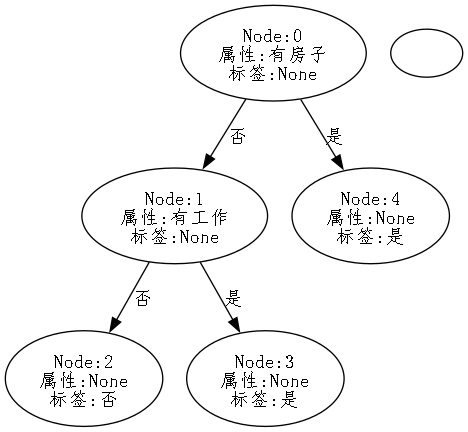

In [8]:
draw(Dtree)